
             FCI Coefficient Visualization - LEVER 0.1.0              

----------------------------------------------------------------------
                        System Initialization                         
----------------------------------------------------------------------
  System                             : N2_sto3g_3.00 
  Nuclear repulsion                  :   8.64322778 Ha
  Initialization time                :         0.00 s

----------------------------------------------------------------------
                          Determinant Space                           
----------------------------------------------------------------------
  Hilbert space dimension            :       14,400 
  Construction time                  :         0.00 s

----------------------------------------------------------------------
                          Hamiltonian Matrix                          
----------------------------------------------------------------------
  Non-zero eleme

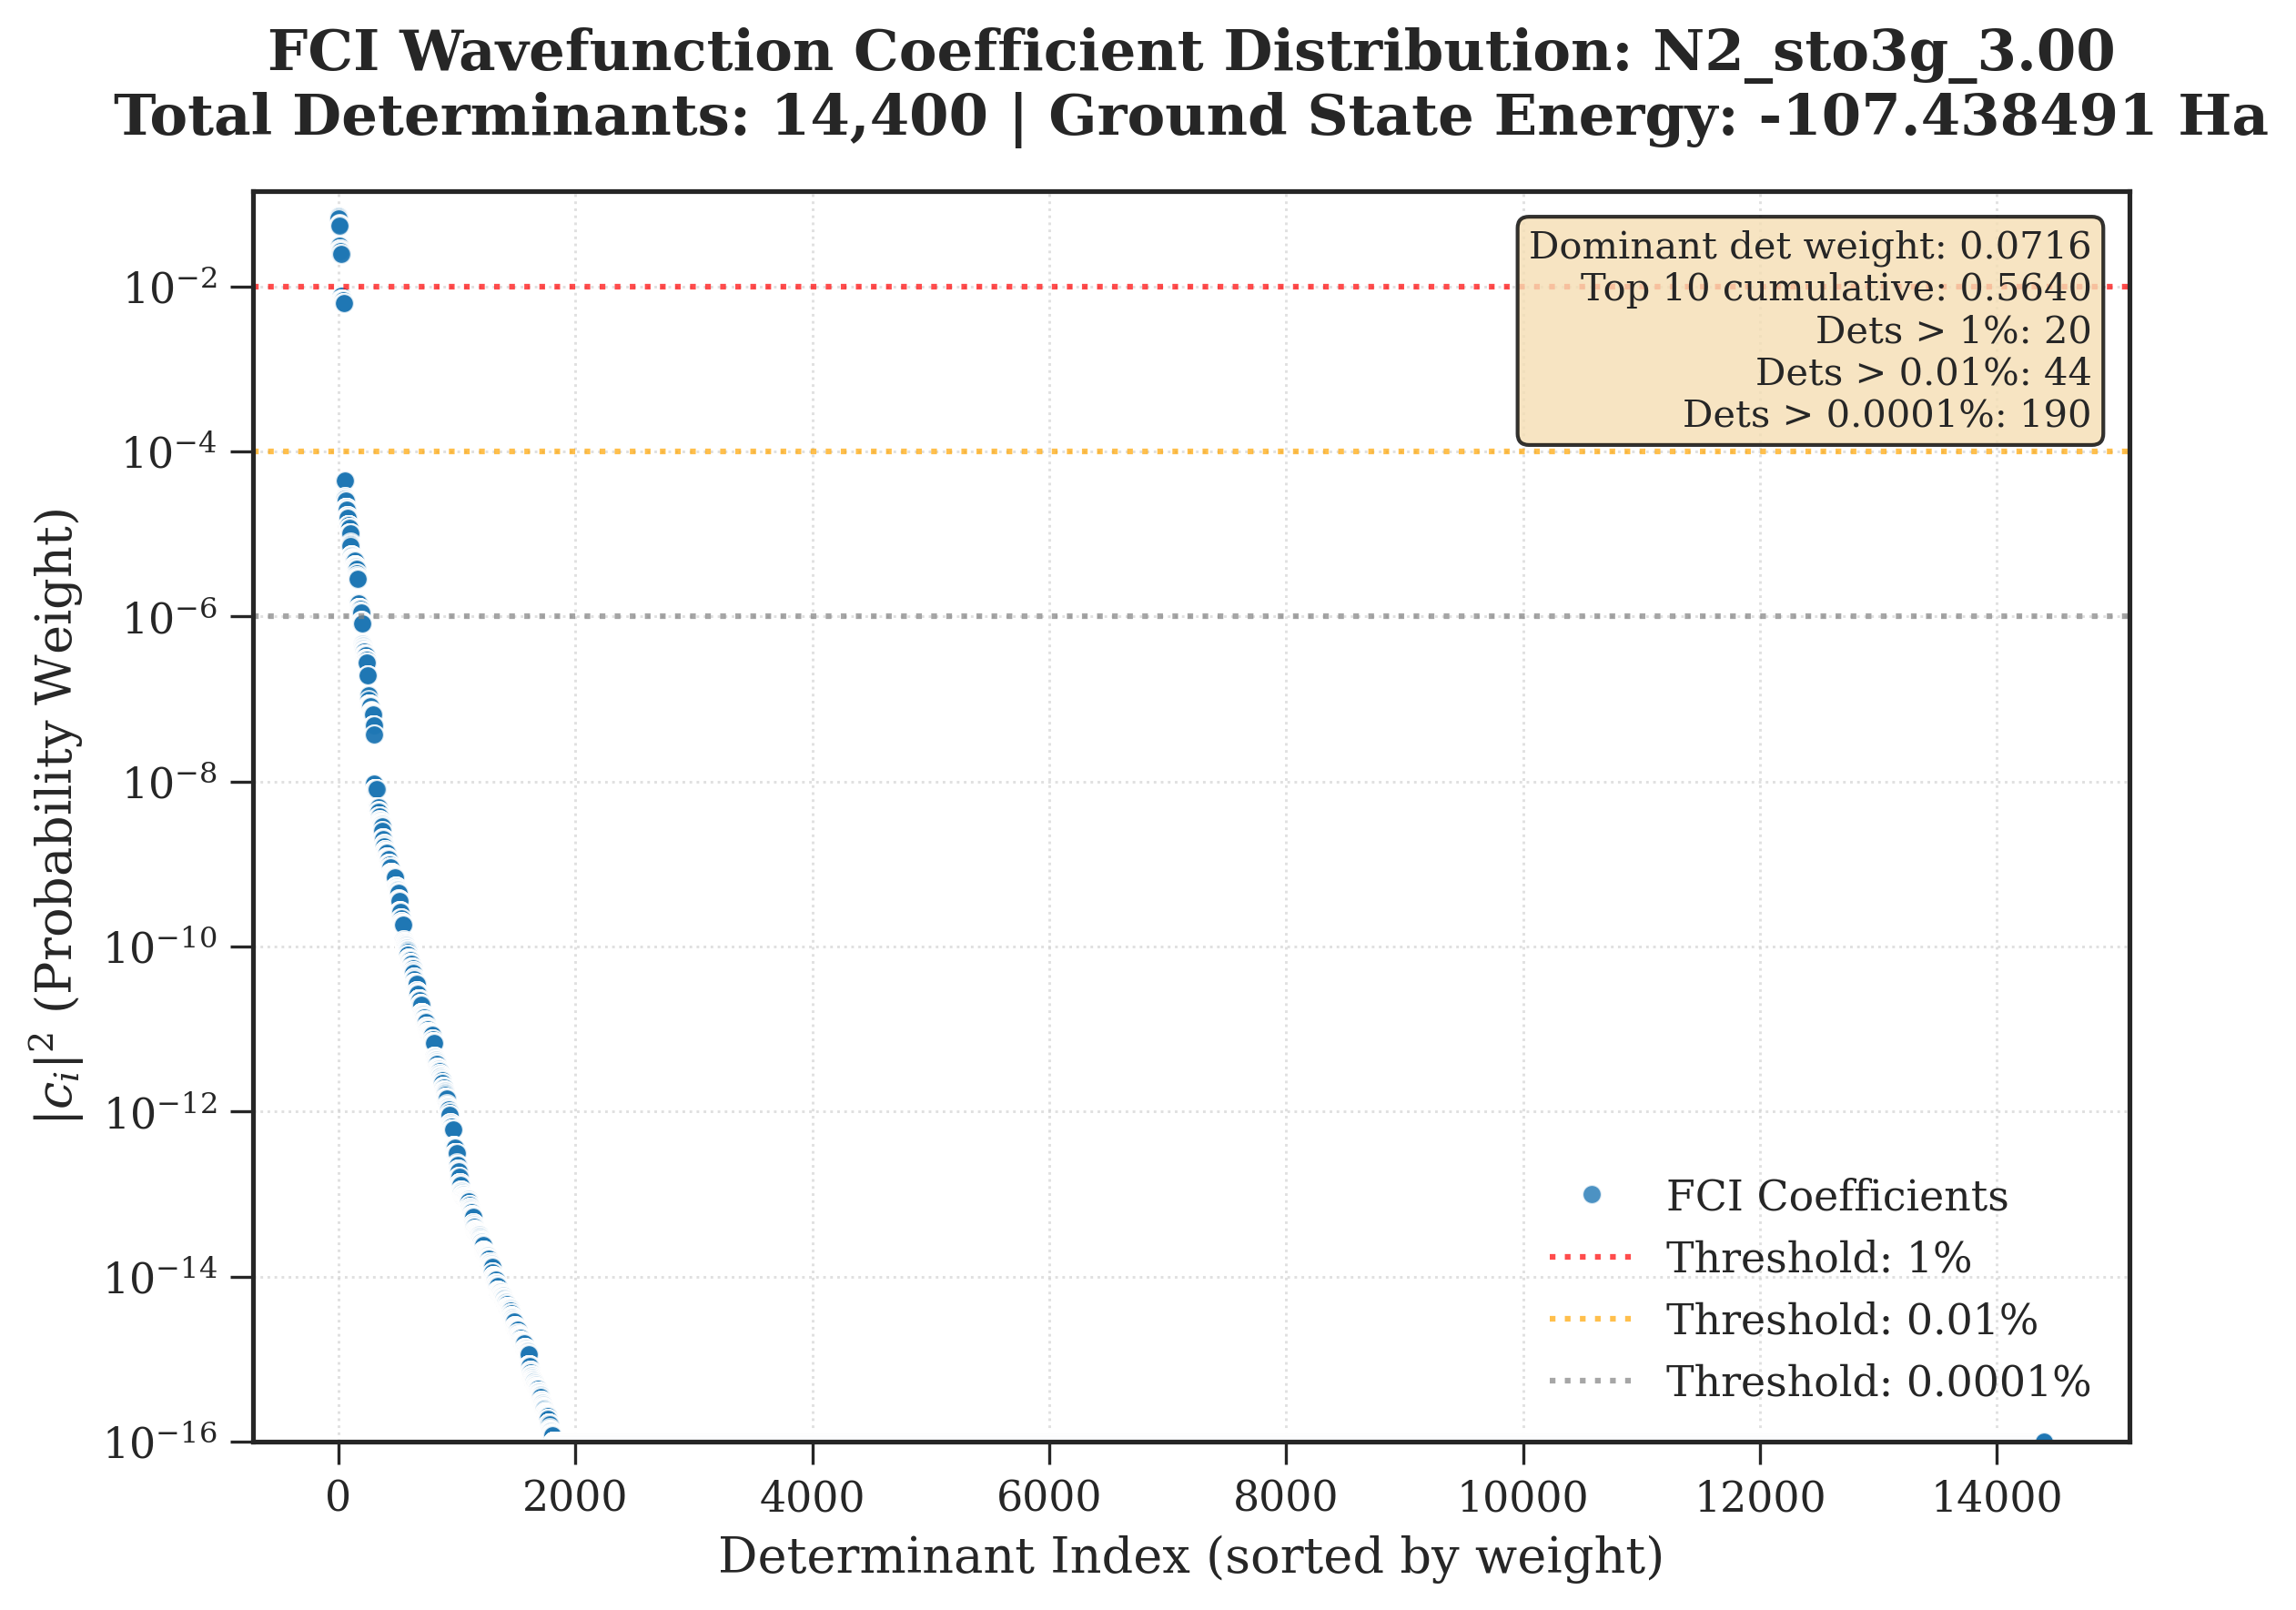

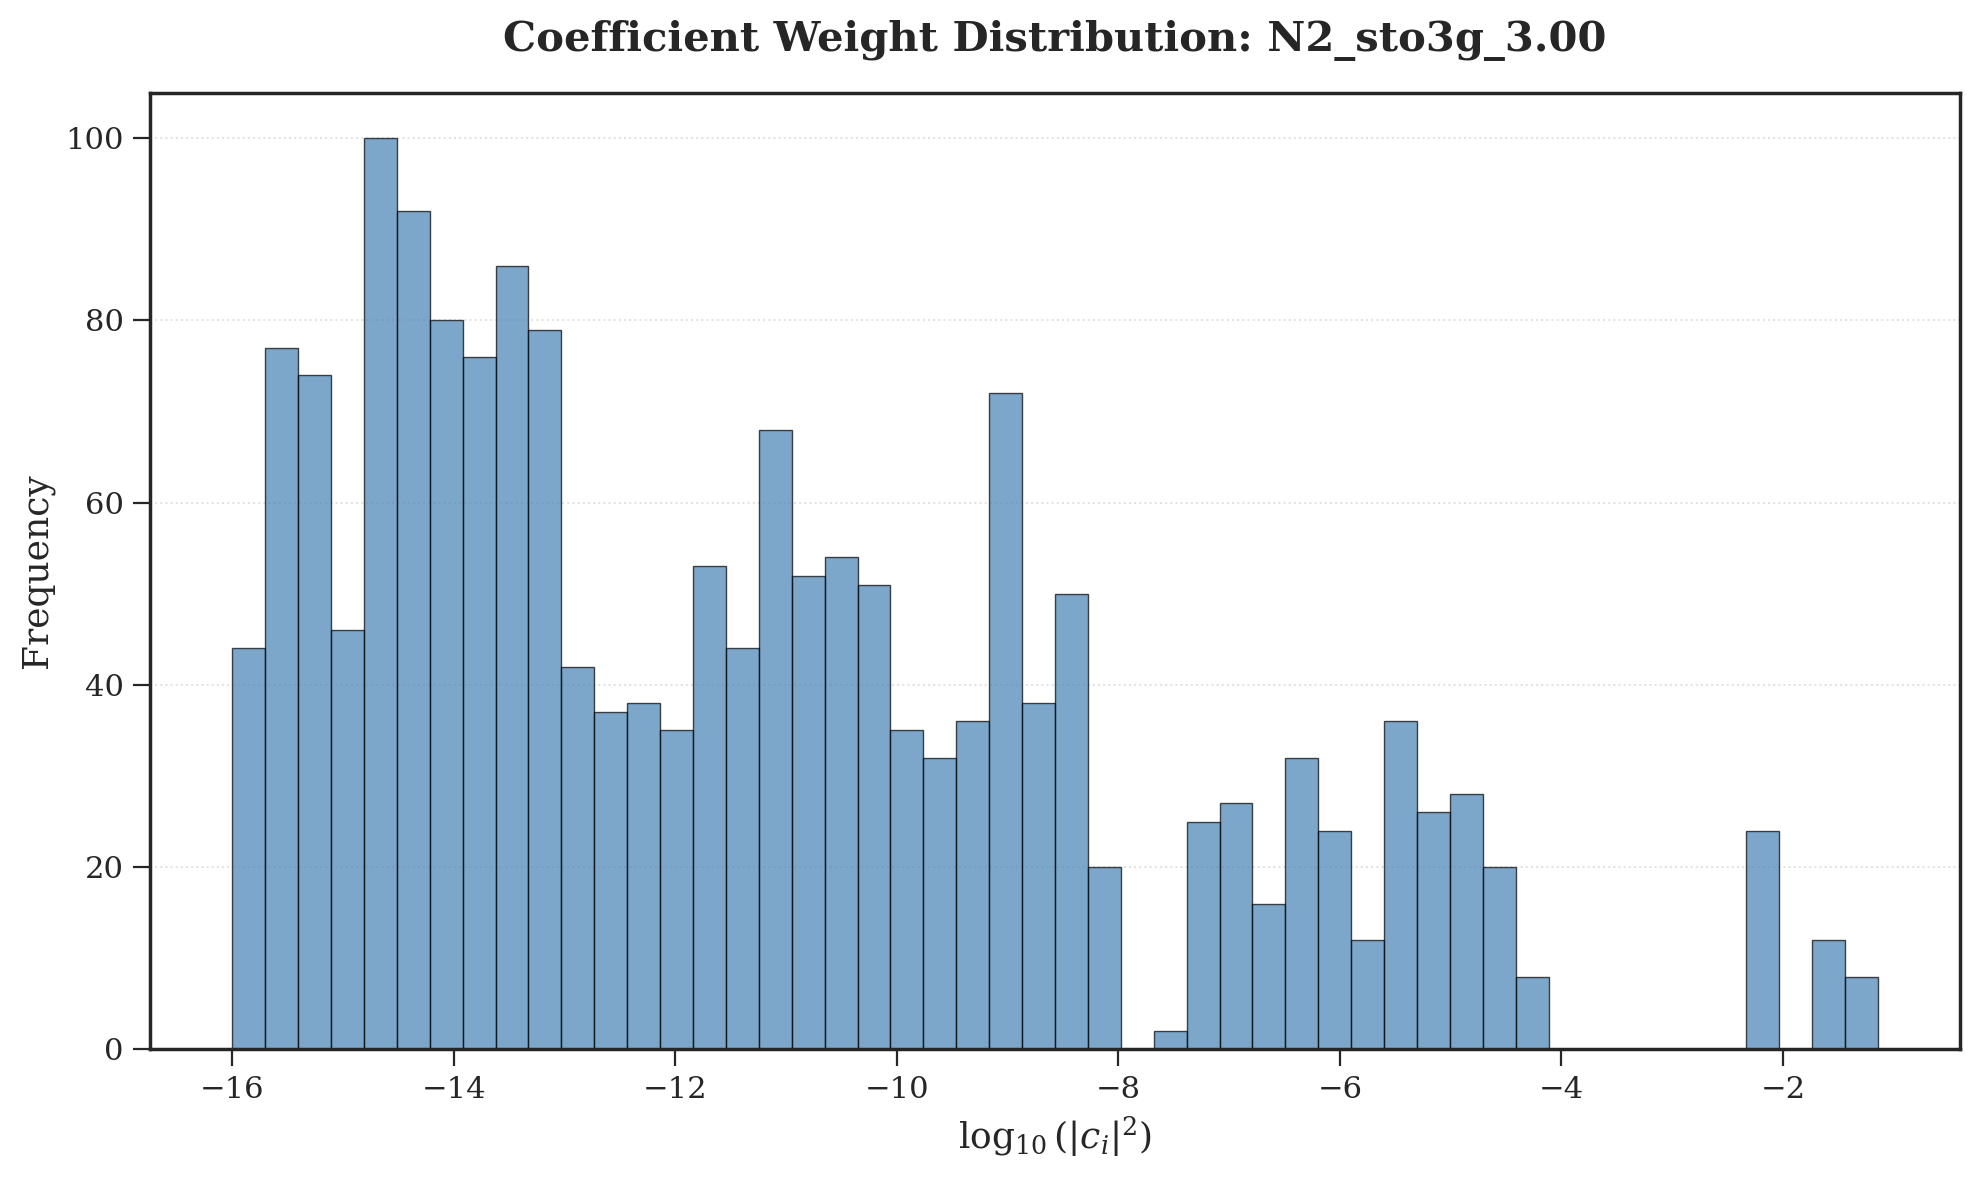


                          Analysis Complete                           


In [2]:
# Copyright 2025 The LEVER Authors - All rights reserved.
# SPDX-License-Identifier: Apache-2.0

"""
FCI coefficient visualization script.

Performs exact diagonalization and visualizes determinant coefficients
squared (probability weights) for quantum chemistry systems.

File: examples/visualize_fci_coefficients.py
Author: Zheng (Alex) Che, email: wsmxcz@gmail.com
Date: January, 2025
"""

from __future__ import annotations

import os
os.environ['JAX_PLATFORMS'] = 'cpu'

import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg

import lever


# System configuration
FCIDUMP_PATH = "../FCIDUMP/N2_sto3g_3.00.FCIDUMP"
NUM_ORBITALS = 10
NUM_ALPHA = 7
NUM_BETA = 7


def print_header(text: str, char: str = "=") -> None:
    """Print formatted section header."""
    width = 70
    print(f"\n{char * width}")
    print(f"{text:^{width}}")
    print(f"{char * width}")


def print_metric(label: str, value: str, unit: str = "", width: int = 35) -> None:
    """Print formatted metric with aligned columns."""
    print(f"  {label:<{width}}: {value:>12} {unit}")


def extract_fci_coefficients(H_csr: scipy.sparse.csr_matrix) -> tuple[float, np.ndarray]:
    """
    Extract ground state coefficients via exact diagonalization.
    
    Computes the lowest eigenvector of the Hamiltonian matrix using
    sparse iterative methods (Lanczos algorithm).
    
    Args:
        H_csr: Sparse Hamiltonian in CSR format
        
    Returns:
        Tuple of (ground state energy, normalized coefficient array)
    """
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(
        H_csr, k=1, which='SA'
    )
    coeffs = eigenvectors[:, 0]
    coeffs_normalized = coeffs / np.linalg.norm(coeffs)
    return eigenvalues[0], coeffs_normalized


def plot_fci_coefficients(
    fci_coeffs: np.ndarray,
    system_name: str,
    energy: float
) -> None:
    """
    Visualize FCI determinant coefficient distribution.
    
    Creates log-scale plot of squared coefficients (probability weights)
    sorted by contribution magnitude, with statistical analysis.
    
    Args:
        fci_coeffs: FCI wavefunction coefficients
        system_name: Chemical system identifier
        energy: Ground state energy in Hartree
    """
    plt.style.use('seaborn-v0_8-ticks')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    
    # Compute probability weights
    n_dets = len(fci_coeffs)
    det_indices = np.arange(n_dets)
    fci_weights = np.abs(fci_coeffs)**2
    
    # Enforce minimum for log scale
    min_weight = 1e-16
    fci_weights_safe = np.maximum(fci_weights, min_weight)
    
    # Sort by weight (descending)
    sort_idx = np.argsort(fci_weights)[::-1]
    
    colors = plt.get_cmap('tab10').colors
    
    # Plot FCI coefficients
    ax.semilogy(
        det_indices, fci_weights_safe[sort_idx], 'o',
        color=colors[0], markersize=5, alpha=0.8,
        label='FCI Coefficients',
        markeredgewidth=0.5, markeredgecolor='white'
    )
    
    # Significance threshold markers
    thresholds = [1e-2, 1e-4, 1e-6]
    threshold_colors = ['red', 'orange', 'gray']
    threshold_labels = ['1%', '0.01%', '0.0001%']
    
    for thresh, color, label in zip(thresholds, threshold_colors, threshold_labels):
        ax.axhline(
            y=thresh, color=color, linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'Threshold: {label}'
        )
    
    ax.set_xlabel('Determinant Index (sorted by weight)', fontsize=13)
    ax.set_ylabel(r'$|c_i|^2$ (Probability Weight)', fontsize=13)
    ax.set_title(
        f'FCI Wavefunction Coefficient Distribution: {system_name}\n'
        f'Total Determinants: {n_dets:,} | Ground State Energy: {energy:.6f} Ha',
        fontsize=15, fontweight='bold', pad=15
    )
    
    ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.6)
    ax.legend(loc='best', framealpha=0.9, fontsize=11)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Set y-axis limits
    max_weight = np.max(fci_weights_safe)
    ax.set_ylim(min_weight, max_weight * 2)
    
    # Statistics analysis
    n_sig_1pct = np.sum(fci_weights > 1e-2)
    n_sig_001pct = np.sum(fci_weights > 1e-4)
    n_sig_0001pct = np.sum(fci_weights > 1e-6)
    dominant_weight = fci_weights[sort_idx[0]]
    cumulative_weight_top10 = np.sum(fci_weights[sort_idx[:10]])
    
    stats_text = (
        f'Dominant det weight: {dominant_weight:.4f}\n'
        f'Top 10 cumulative: {cumulative_weight_top10:.4f}\n'
        f'Dets > 1%: {n_sig_1pct}\n'
        f'Dets > 0.01%: {n_sig_001pct}\n'
        f'Dets > 0.0001%: {n_sig_0001pct}'
    )
    
    ax.text(
        0.98, 0.97, stats_text,
        transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    )
    
    plt.tight_layout()
    plt.savefig(fname='FCI_coefficients.pdf',format='pdf', dpi=300)
    plt.show()


def plot_coefficient_histogram(
    fci_coeffs: np.ndarray,
    system_name: str
) -> None:
    """
    Create histogram of coefficient magnitude distribution.
    
    Args:
        fci_coeffs: FCI wavefunction coefficients
        system_name: Chemical system identifier
    """
    plt.style.use('seaborn-v0_8-ticks')
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
    
    fci_weights = np.abs(fci_coeffs)**2
    log_weights = np.log10(fci_weights[fci_weights > 1e-16])
    
    ax.hist(
        log_weights, bins=50, color='steelblue', alpha=0.7,
        edgecolor='black', linewidth=0.5
    )
    
    ax.set_xlabel(r'$\log_{10}(|c_i|^2)$', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.set_title(
        f'Coefficient Weight Distribution: {system_name}',
        fontsize=15, fontweight='bold', pad=15
    )
    
    ax.grid(True, axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    plt.tight_layout()
    plt.show()


def main() -> None:
    """Execute FCI diagonalization and coefficient visualization."""
    
    print_header(f"FCI Coefficient Visualization - LEVER {lever.__version__}")
    
    # System initialization
    print_header("System Initialization", char="-")
    
    if not Path(FCIDUMP_PATH).exists():
        raise FileNotFoundError(f"FCIDUMP not found: {FCIDUMP_PATH}")
    
    t0 = time.time()
    int_ctx = lever.IntCtx(FCIDUMP_PATH, NUM_ORBITALS)
    e_nuc = int_ctx.get_e_nuc()
    print_metric("System", Path(FCIDUMP_PATH).stem)
    print_metric("Nuclear repulsion", f"{e_nuc:.8f}", "Ha")
    print_metric("Initialization time", f"{time.time() - t0:.2f}", "s")
    
    # Determinant space construction
    print_header("Determinant Space", char="-")
    
    t0 = time.time()
    S_dets = lever.core.gen_fci_dets(NUM_ORBITALS, NUM_ALPHA, NUM_BETA)
    size_S = S_dets.shape[0]
    print_metric("Hilbert space dimension", f"{size_S:,}")
    print_metric("Construction time", f"{time.time() - t0:.2f}", "s")
    
    # Hamiltonian matrix assembly
    print_header("Hamiltonian Matrix", char="-")
    
    t0 = time.time()
    ham_ss, ham_sc, space_rep = lever.hamiltonian.get_ham_ops(
        S_dets=S_dets, int_ctx=int_ctx, n_orbitals=NUM_ORBITALS,
        use_heatbath=False
    )
    sparsity = 100 * ham_ss.nnz / (size_S ** 2)
    print_metric("Non-zero elements", f"{ham_ss.nnz:,}")
    print_metric("Sparsity", f"{sparsity:.2f}", "%")
    print_metric("Assembly time", f"{time.time() - t0:.2f}", "s")
    
    # Exact diagonalization
    print_header("Exact Diagonalization", char="-")
    
    t0 = time.time()
    H_csr = scipy.sparse.coo_matrix(
        (ham_ss.vals, (ham_ss.rows, ham_ss.cols)),
        shape=ham_ss.shape
    ).tocsr()
    H_csr.sum_duplicates()
    
    print("  Performing sparse diagonalization...")
    fci_energy_elec, fci_coeffs = extract_fci_coefficients(H_csr)
    fci_energy_total = fci_energy_elec + e_nuc
    
    print_metric("Electronic energy", f"{fci_energy_elec:.8f}", "Ha")
    print_metric("Total energy", f"{fci_energy_total:.8f}", "Ha")
    print_metric("Diagonalization time", f"{time.time() - t0:.2f}", "s")
    
    # Wavefunction analysis
    print_header("Wavefunction Analysis", char="-")
    
    fci_weights = np.abs(fci_coeffs)**2
    dominant_idx = np.argmax(fci_weights)
    dominant_weight = fci_weights[dominant_idx]
    
    # Count significant determinants
    n_sig_1pct = np.sum(fci_weights > 1e-2)
    n_sig_001pct = np.sum(fci_weights > 1e-4)
    n_sig_0001pct = np.sum(fci_weights > 1e-6)
    
    # Cumulative weight analysis
    sorted_weights = np.sort(fci_weights)[::-1]
    cumsum = np.cumsum(sorted_weights)
    n_for_90pct = np.searchsorted(cumsum, 0.90) + 1
    n_for_99pct = np.searchsorted(cumsum, 0.99) + 1
    
    print_metric("Dominant determinant", f"{dominant_idx}")
    print_metric("Dominant weight", f"{dominant_weight:.6f}")
    print_metric("Dets > 1%", f"{n_sig_1pct}")
    print_metric("Dets > 0.01%", f"{n_sig_001pct}")
    print_metric("Dets > 0.0001%", f"{n_sig_0001pct}")
    print_metric("Dets for 90% weight", f"{n_for_90pct}")
    print_metric("Dets for 99% weight", f"{n_for_99pct}")
    
    # Visualization
    print_header("Generating Visualizations", char="-")
    
    plot_fci_coefficients(
        fci_coeffs,
        system_name=Path(FCIDUMP_PATH).stem,
        energy=fci_energy_total
    )
    
    plot_coefficient_histogram(
        fci_coeffs,
        system_name=Path(FCIDUMP_PATH).stem
    )
    
    print_header("Analysis Complete", char="=")


if __name__ == "__main__":
    main()
